## Researching the factors that affect data science salaries in 2023 and creating a predictive model for the salary.

In [1]:
!pip install pycountry

In [2]:
!pip install scikit-posthocs

In [3]:
import numpy as np #for linear algebra and vectorization
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for visualization
import seaborn as sns #for visualization
import plotly.express as px # for visualization
import pycountry #for country conversion
from scipy.stats import anderson# for normality test
import pingouin as pg #for statistical tests
from scikit_posthocs import posthoc_dunn #to figure out pairwise differences so that we can know which groups specifically are statistically different


In [4]:
#read the dataset
data=pd.read_csv('/kaggle/input/data-science-salaries-2023/ds_salaries.csv') ## replace file path here

## Data Dictionary

### Fields and Descriptions

- **work_year**
  - **Description:** The year the salary was paid.
  - **Type:** Year (e.g., 2021, 2022)

- **experience_level**
  - **Description:** The experience level in the job during the year.
  - **Possible Values:**
    - `EN` - Entry-level / Junior
    - `MI` - Mid-level / Intermediate
    - `SE` - Senior-level / Expert
    - `EX` - Executive-level / Director

- **employment_type**
  - **Description:** The type of employment for the role.
  - **Possible Values:**
    - `PT` - Part-time
    - `FT` - Full-time
    - `CT` - Contract
    - `FL` - Freelance

- **job_title**
  - **Description:** The role worked in during the year.
  - **Type:** Text (e.g., Software Engineer, Data Scientist)

- **salary**
  - **Description:** The total gross salary amount paid.
  - **Type:** Numeric

- **salary_currency**
  - **Description:** The currency of the salary paid as an ISO 4217 currency code.
  - **Type:** ISO 4217 currency code (e.g., USD, EUR)

- **salary_in_usd**
  - **Description:** The salary in USD, adjusted by the average exchange rate for the respective year.
  - **Type:** Numeric

- **employee_residence**
  - **Description:** Employee's primary country of residence during the work year.
  - **Type:** ISO 3166 country code (e.g., US, GB)

- **remote_ratio**
  - **Description:** The overall amount of work done remotely.
  - **Possible Values:**
    - `0` - No remote work (less than 20%)
    - `50` - Partially remote/hybrid
    - `100` - Fully remote (more than 80%)

- **company_location**
  - **Description:** The country of the employer's main office or contracting branch.
  - **Type:** ISO 3166 country code (e.g., US, GB)

- **company_size**
  - **Description:** The average number of people that worked for the company during the year.
  - **Possible Values:**
    - `S` - less than 50 employees (small)
    - `M` - 50 to 250 employees (medium)
    - `L` - more than 250 employees (large)


In [5]:
#check the first few rows of the data
data.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [6]:
#Checking the columns and basic info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


No nulls (missing values) in the data set. More than half of our data is categorical.

In [7]:
#simple descriptive statistics
data.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,3755.000000,3755,3755,3755,3.755000e+03,3755,3755.000000,3755,3755.000000,3755,3755
unique,NaN,4,4,93,NaN,20,NaN,78,NaN,72,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,2516,3718,1040,NaN,3224,NaN,3004,NaN,3040,3153
mean,2022.373635,NaN,NaN,NaN,1.906956e+05,NaN,137570.389880,NaN,46.271638,NaN,NaN
std,0.691448,NaN,NaN,NaN,6.716765e+05,NaN,63055.625278,NaN,48.589050,NaN,NaN
min,2020.000000,NaN,NaN,NaN,6.000000e+03,NaN,5132.000000,NaN,0.000000,NaN,NaN
25%,2022.000000,NaN,NaN,NaN,1.000000e+05,NaN,95000.000000,NaN,0.000000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,1.380000e+05,NaN,135000.000000,NaN,0.000000,NaN,NaN
75%,2023.000000,NaN,NaN,NaN,1.800000e+05,NaN,175000.000000,NaN,100.000000,NaN,NaN


### Data Cleaning

In [8]:
import pycountry

# Function to convert 2-letter codes to 3-letter codes
def convert_alpha2_to_alpha3_single(alpha2_code):
    country = pycountry.countries.get(alpha_2=alpha2_code)
    if country is not None:
        return country.alpha_3
    else:
        return "Unknown" 

data['company_location'] = data['company_location'].apply(convert_alpha2_to_alpha3_single)
data['employee_residence']=data['employee_residence'].apply(convert_alpha2_to_alpha3_single)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ESP,100,ESP,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,USA,100,USA,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,USA,100,USA,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CAN,100,CAN,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CAN,100,CAN,M


In [9]:


data['experience_level']= data['experience_level'].astype('category')
data['experience_level'] = data['experience_level'].cat.reorder_categories(new_categories=['EN','MI','SE', 'EX'],ordered=True)


data['experience_level'].value_counts()

experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64

In [10]:
data['employment_type'] = data['employment_type'].astype('category')

data['employment_type'].cat.categories

Index(['CT', 'FL', 'FT', 'PT'], dtype='object')

In [11]:
#taken from here https://www.kaggle.com/code/nanthaphat/data-science-salaries-in-us-2023?scriptVersionId=166105969&cellId=17
# set all 'job_title' to lowwer case for easy to make category
data['job_title'] = data['job_title'].str.lower()

# make cetogory list condition: 
data_analyst_cate_list = data['job_title'].str.contains(
                                        'data analyst|analyst|analysis|analytic|bi|business')
data_scientist_cate_list = data['job_title'].str.contains(
                                        'data scientist|scientist|ai|ml|machine learning|deep lerning|model')
data_engineer_cate_list = data['job_title'].str.contains(
                                    'data engineer|engineer|architect|db|database|azure}etl')

# set condition
condition_list = [data_analyst_cate_list, 
                  data_scientist_cate_list, 
                  data_engineer_cate_list]
# set value
value_list = ['data analyst', 
              'data scientist', 
              'data engineer']

data['job_category'] = np.select(condition_list, value_list, default='others')
#change data type and reorder
data['job_category'] = data['job_category'].astype('category')
data['job_category'] = data['job_category'].cat.reorder_categories(
                        new_categories=['data engineer', 'data analyst','data scientist', 'others'],
                        ordered=True)
#change other data type to'category' type
data['company_size'] = data['company_size'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')
data['work_year'] = data['work_year'].astype('category')

data['job_category'].value_counts()

job_category
data scientist    1455
data engineer     1260
data analyst       853
others             187
Name: count, dtype: int64

In [12]:
data=data.drop(columns=['salary','salary_currency','job_title'])
data.head()


,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
0,2023,SE,FT,85847,ESP,100,ESP,L,data scientist
1,2023,MI,CT,30000,USA,100,USA,S,data scientist
2,2023,MI,CT,25500,USA,100,USA,S,data scientist
3,2023,SE,FT,175000,CAN,100,CAN,M,data scientist
4,2023,SE,FT,120000,CAN,100,CAN,M,data scientist


**Exploratory Data Analysis**




/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


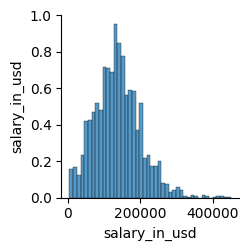

In [13]:
sns.pairplot(data)

<Axes: xlabel='salary_in_usd'>

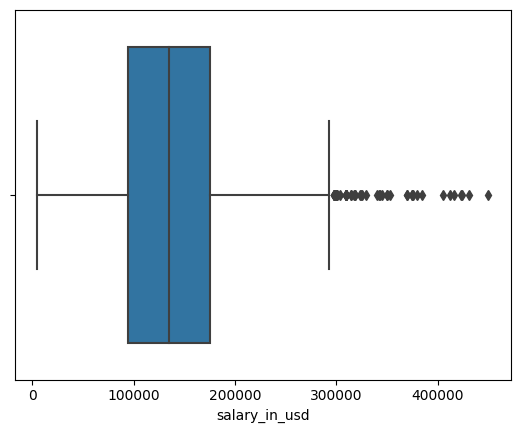

In [14]:
sns.boxplot(data=data,x='salary_in_usd') #using salary_in_usd to unify the salaries

**Investigating outliers in Salary**

In [15]:
q1=data.salary_in_usd.quantile(0.25)
q3=data.salary_in_usd.quantile(0.75)
iqr=q3-q1
mask=(data.salary_in_usd < q1 - 1.5 * iqr) | (data.salary_in_usd > q3 +1.5 * iqr)
potential_outliers=data[mask]


Number of potential outliers 63


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

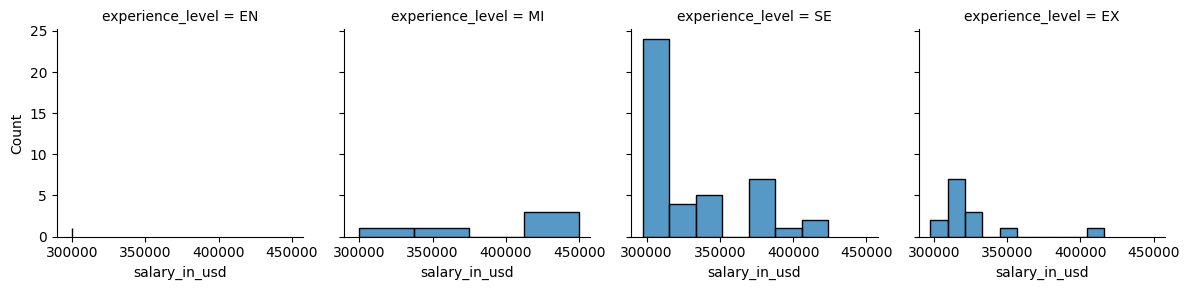

In [16]:
print(f"Number of potential outliers {potential_outliers.shape[0]}")
g=sns.FacetGrid(data=potential_outliers,col='experience_level')
g.map_dataframe(sns.histplot,'salary_in_usd')

Outliers seem natural as its expected for different employees around the world to have different salaries even with the same experience levels.

In [17]:
sal_by_comp_location=data.groupby('company_location')['salary_in_usd'].median().reset_index()
fig = px.choropleth(
    sal_by_comp_location,
    locations='company_location',
    color='salary_in_usd',
    color_continuous_scale=px.colors.sequential.tempo
)

fig.update_layout(title='Median Salary In USD by Country')

# Show the plot
fig.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='work_year', ylabel='count'>

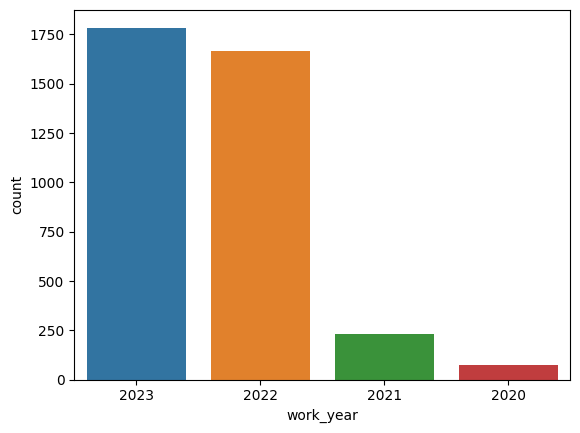

In [18]:
sns.countplot(data=data,x='work_year',order=data['work_year'].value_counts().index)

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='experience_level', ylabel='count'>

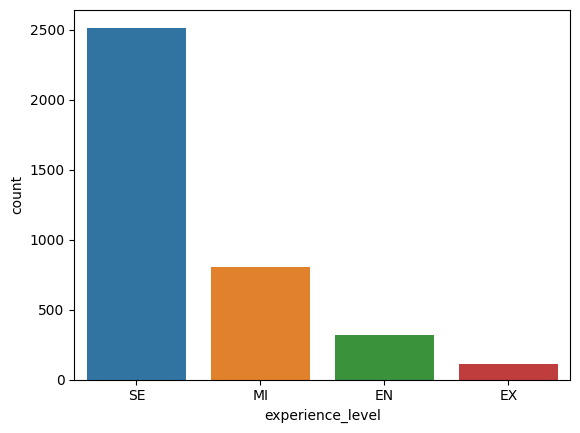

In [19]:
sns.countplot(data=data,x='experience_level',order=data['experience_level'].value_counts().index)

In [20]:
data.employment_type.value_counts() # most employees are full time.

employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64

/tmp/ipykernel_1466/1275740394.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_1466/1275740394.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: title={'center': 'Mean Salary In USD By Experience Level'}, xlabel='experience_level', ylabel='salary_in_usd'>

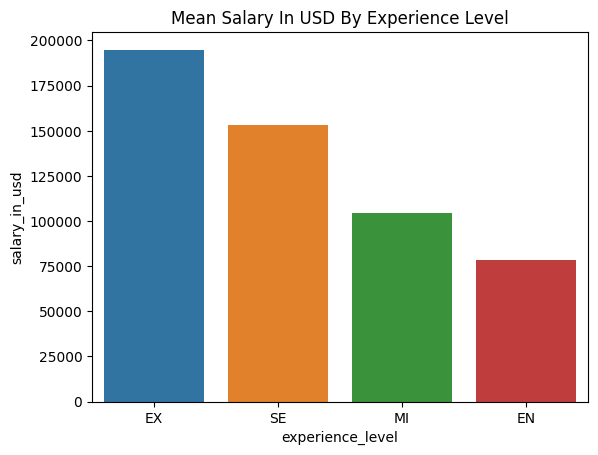

In [21]:
salary_by_experience=data.groupby('experience_level')['salary_in_usd'].mean().reset_index()
order=data.groupby('experience_level')['salary_in_usd'].mean().sort_values(ascending=False).index
plt.title('Mean Salary In USD By Experience Level')
sns.barplot(data=salary_by_experience,x='experience_level',y='salary_in_usd',order=order)

/tmp/ipykernel_1466/2385034288.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: title={'center': 'Mean Salary in USD By Remote Ratio'}, xlabel='remote_ratio', ylabel='salary_in_usd'>

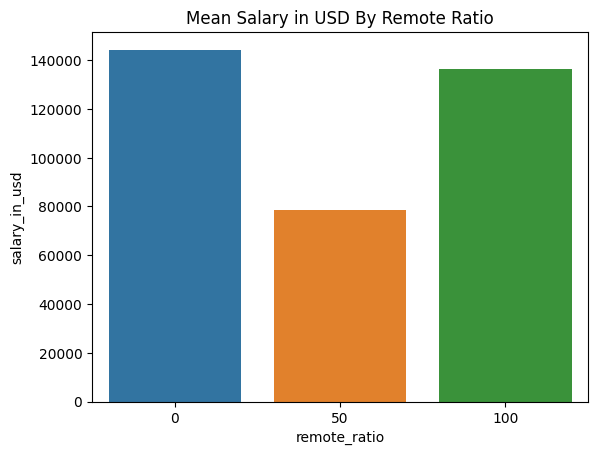

In [22]:
salary_by_remote=data.groupby('remote_ratio')['salary_in_usd'].mean().reset_index()
plt.title('Mean Salary in USD By Remote Ratio')
sns.barplot(data=salary_by_remote,x='remote_ratio',y='salary_in_usd')

As expected completely on site are the highest paid employees however completely remote employees are not far off behind, seems like employees that are 50-50 are paid least by a good margin, this could be further investigated as to why, it could relate to multiple reasons as maybe most 50-50 employees data were recorded in a tough year like COVID.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/cond

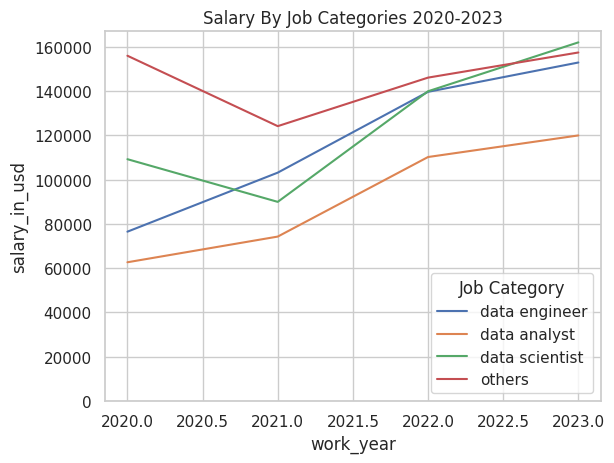

In [23]:
sns.set_theme(style='whitegrid')
sns.lineplot(data=data,x='work_year',y='salary_in_usd',hue='job_category',errorbar=None)
plt.ylim(0)
plt.legend(title='Job Category', title_fontsize='12', loc='lower right')
plt.title('Salary By Job Categories 2020-2023')
plt.show()

The graph depicts the salary evolution of various professional roles from 2020 to 2023. It's observed that the salary levels for 'Data Scientists' and the 'Others' group initially decrease between 2020 and 2021 but then recover and ascend significantly until 2023. In contrast, 'Data Engineers' and 'Data Analysts' experience a more steady and progressive increase in salary throughout the four-year span.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/cond

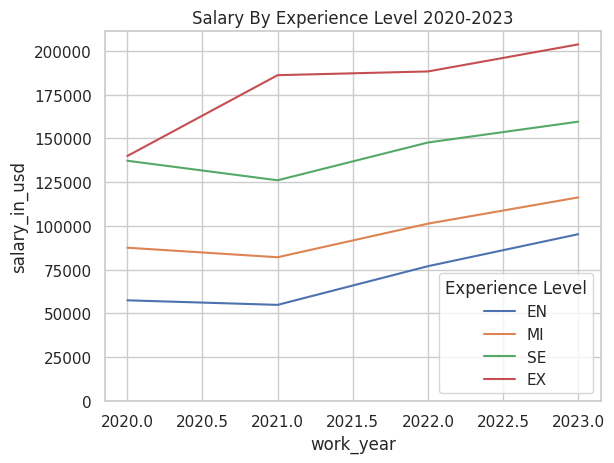

In [24]:
sns.set_theme(style='whitegrid')
sns.lineplot(data=data,x='work_year',y='salary_in_usd',hue='experience_level',errorbar=None)
plt.ylim(0)
plt.legend(title='Experience Level', title_fontsize='12', loc='lower right')
plt.title('Salary By Experience Level 2020-2023')
plt.show()


The graph shows the salary progression from 2020 to 2023 based on experience levels: entry-level (EN), mid-level (MI), senior-level (SE), and executive-level (EX). Over these four years, executive-level salaries are the highest and show a steady increase, while senior-level salaries also rise consistently but at a lower overall pay scale compared to executives. Mid-level positions show modest growth, and entry-level salaries are the lowest, albeit with a gradual upward trend. All levels except Executives notice a decrease in 2021 but then they continue to rise.

## Testing If the mean across Job categories is statistically significant

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Figure size 1200x1000 with 0 Axes>

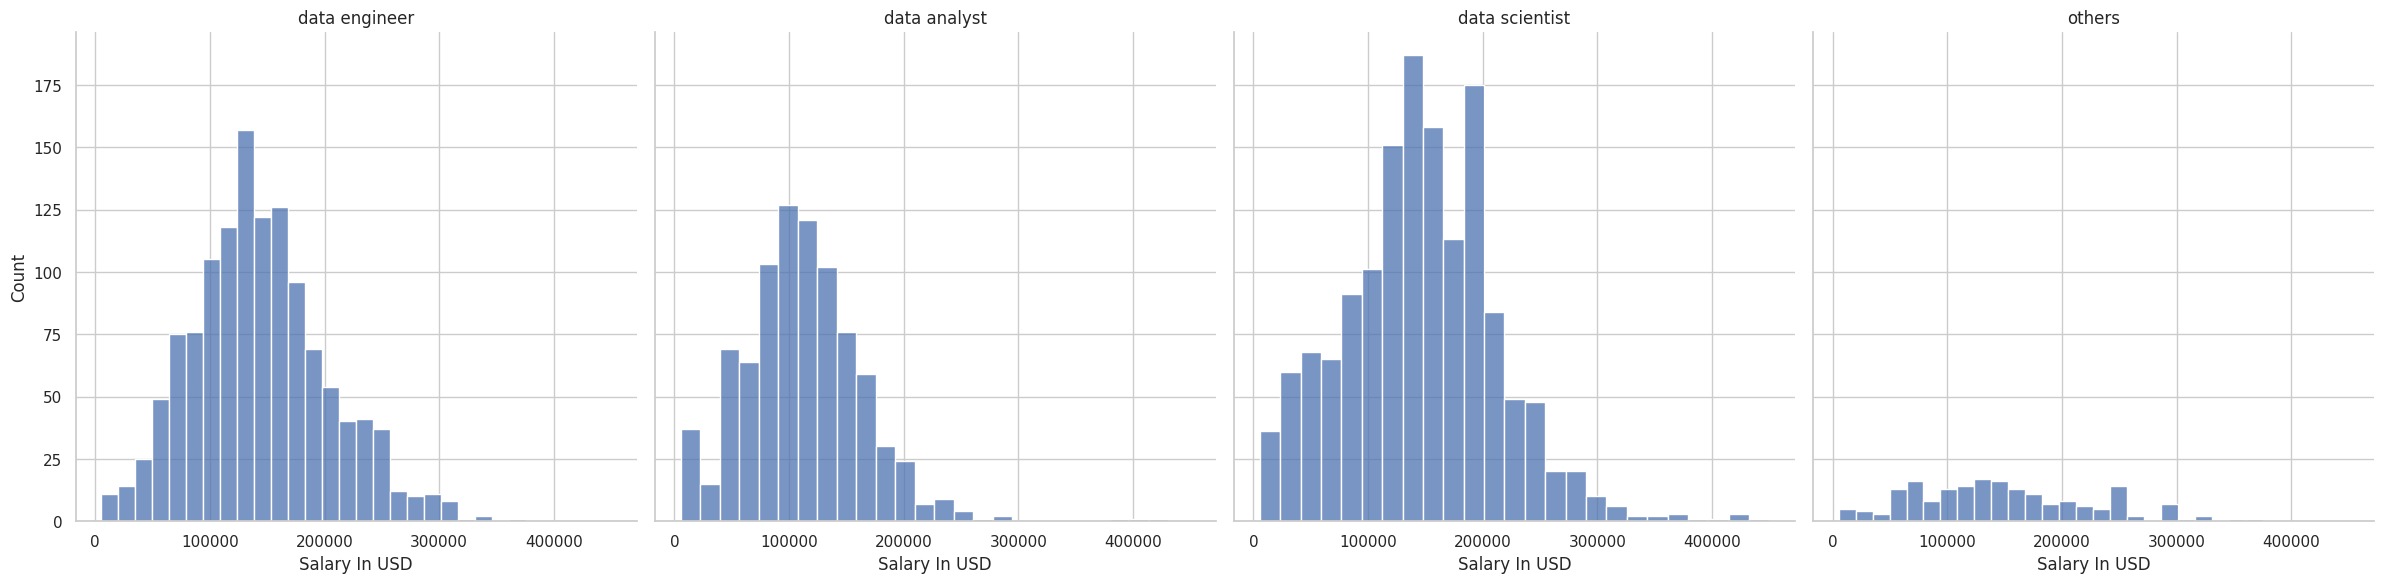

In [25]:
plt.figure(figsize=(12,10))
g=sns.FacetGrid(data=data,col='job_category',height=6)
g.map_dataframe(sns.histplot,'salary_in_usd',bins=25)
g.set_axis_labels('Salary In USD', 'Count')
g.set_titles(col_template="{col_name}")
plt.show()

They seem normally distributed except the others category, we may have to remove the others category from our anova test as it assumes normality. However we'll still need to statistically test for normality. 

In [26]:
job_category = ['data scientist', 'data analyst','data engineer']


for i in job_category:
    sal = data[data['job_category'] == i]['salary_in_usd']
    result = anderson(sal) 
    
    print(f'Testing for : {i}:')
    print(result.statistic)
    if result.statistic > result.critical_values[2]:
        print('The distribution is unlikely to be normal at 95% confidence level.')
    else:
        print('The distribution is likely to be normal at 95% confidence level.')


Testing for : data scientist:
3.318467876044906
The distribution is unlikely to be normal at 95% confidence level.
Testing for : data analyst:
2.581384363447455
The distribution is unlikely to be normal at 95% confidence level.
Testing for : data engineer:
4.197405830760999
The distribution is unlikely to be normal at 95% confidence level.



The Anderson-Darling test statistics for the data scientist, data analyst, and data engineer categories are 3.32, 2.58, and 4.20, respectively. These values exceed the critical value at a 95% confidence level, indicating that the distributions of salaries for all three job categories are unlikely to be normal. Therefore, we have evidence to reject the hypothesis that the salary distributions follow a normal distribution for each job category.
After all they werent normally distributed atleast at 95% confidence level.

## ANOVA

In [27]:


# Perform Welch's ANOVA since the different groups have different variances and not normally distributed.
welch_anova_result = pg.welch_anova(data=data, dv='salary_in_usd', between='job_category')

# Print the result
print(welch_anova_result)


         Source  ddof1       ddof2          F         p-unc       np2
0  job_category      3  796.305238  79.593291  4.875476e-45  0.048989


Welch's Anova results suggest that there are statistically significant differences in salaries between the different job categories. The job category factor explains a significant proportion (approximately 4.9%) of the variance in salaries.

In [28]:
dunn_result = posthoc_dunn(data, val_col='salary_in_usd', group_col='job_category')
print(dunn_result)

                data engineer  data analyst  data scientist        others
data engineer    1.000000e+00  6.010032e-33    1.606509e-01  9.655473e-01
data analyst     6.010032e-33  1.000000e+00    8.420861e-42  6.863634e-11
data scientist   1.606509e-01  8.420861e-42    1.000000e+00  4.601945e-01
others           9.655473e-01  6.863634e-11    4.601945e-01  1.000000e+00


/opt/conda/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Seems like there is a significant difference between salaries of data analysts and data engineers, data analysts and data scientists,data analysts and others. However it seems that the difference between data scientists and data engineer is statistically insignificant.

## Modeling

In [29]:
ml_data=data.drop(columns=['employee_residence','company_location'])
ml_data.head()

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size,job_category
0,2023,SE,FT,85847,100,L,data scientist
1,2023,MI,CT,30000,100,S,data scientist
2,2023,MI,CT,25500,100,S,data scientist
3,2023,SE,FT,175000,100,M,data scientist
4,2023,SE,FT,120000,100,M,data scientist


In [30]:
ml_data['remote_ratio']=ml_data['remote_ratio'].cat.rename_categories({100:'Remote',50: ' Hybrid',0:'On Site'})
ml_data.head()

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size,job_category
0,2023,SE,FT,85847,Remote,L,data scientist
1,2023,MI,CT,30000,Remote,S,data scientist
2,2023,MI,CT,25500,Remote,S,data scientist
3,2023,SE,FT,175000,Remote,M,data scientist
4,2023,SE,FT,120000,Remote,M,data scientist


In [31]:
ml_dummy=pd.get_dummies(ml_data)
ml_dummy.head()

,salary_in_usd,work_year_2020,work_year_2021,work_year_2022,work_year_2023,experience_level_EN,experience_level_MI,experience_level_SE,experience_level_EX,employment_type_CT,...,remote_ratio_On Site,remote_ratio_ Hybrid,remote_ratio_Remote,company_size_L,company_size_M,company_size_S,job_category_data engineer,job_category_data analyst,job_category_data scientist,job_category_others
0,85847,False,False,False,True,False,False,True,False,False,...,False,False,True,True,False,False,False,False,True,False
1,30000,False,False,False,True,False,True,False,False,True,...,False,False,True,False,False,True,False,False,True,False
2,25500,False,False,False,True,False,True,False,False,True,...,False,False,True,False,False,True,False,False,True,False
3,175000,False,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
4,120000,False,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False


## Random Forest Regressor


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [34]:
X=ml_dummy.drop(columns='salary_in_usd')
y=ml_dummy['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}



In [36]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)


In [37]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print(f"Best params {best_params}")

Best params {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [46]:
y_pred = best_rf.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**(1/2)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 54889.527928738986


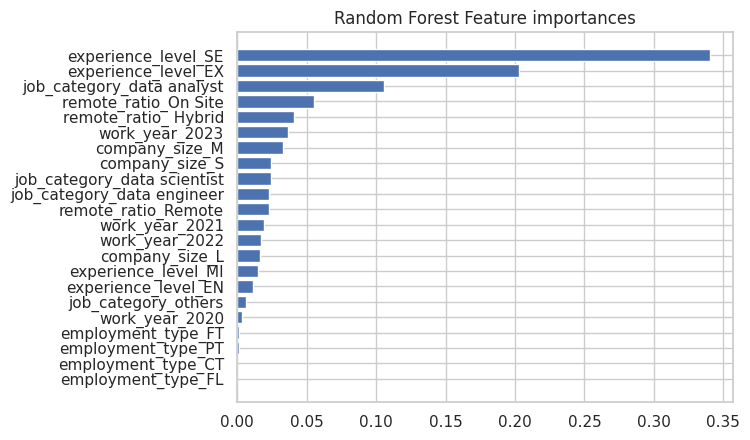

In [63]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure()
plt.title("Random Forest Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.gca().invert_yaxis() 
plt.show()

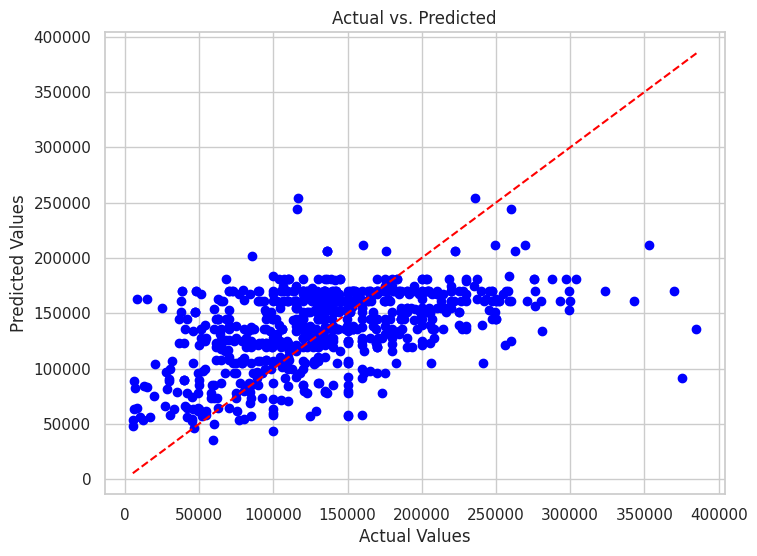

In [40]:
# Plotting actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## XGBoost

In [48]:
from xgboost import XGBRegressor
from xgboost import plot_importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}


xgb = XGBRegressor()

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

xgb_grid.fit(X_train, y_train)

best_xgb_params = xgb_grid.best_params_
best_xgb = xgb_grid.best_estimator_

y_pred = best_xgb.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**(1/2)
print(best_xgb_params)
print("XGBoost Root Mean Squared Error:", rmse)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost Root Mean Squared Error: 54802.17118325491


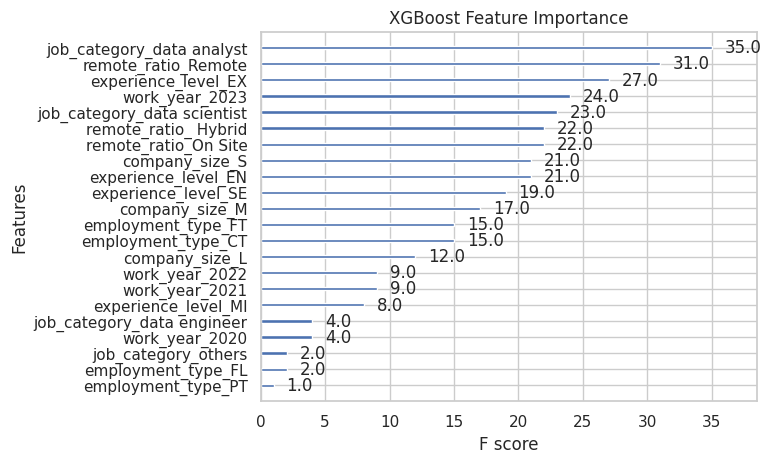

In [64]:
plot_importance(best_xgb)
plt.title('XGBoost Feature Importance')
plt.show()

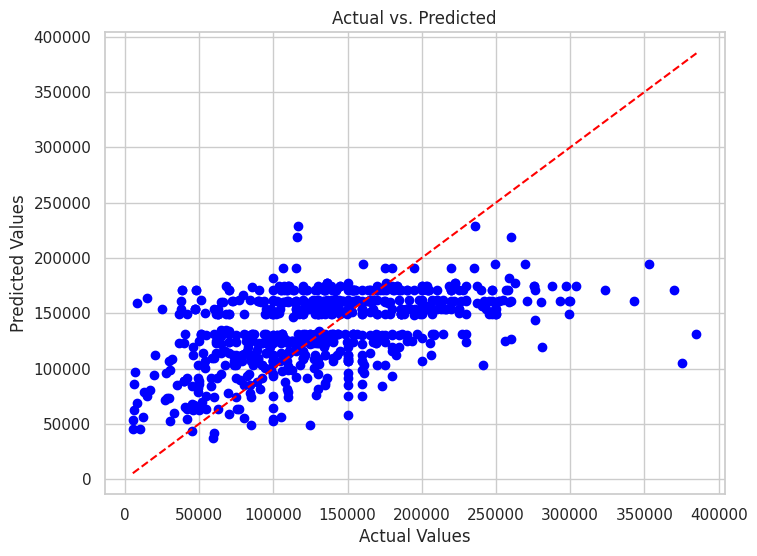

In [42]:
# Plotting actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


## SVR

In [47]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svr = SVR()

svr_grid = GridSearchCV(estimator=svr, param_grid=svr_params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

svr_grid.fit(X_train_scaled, y_train)

best_svr_params = svr_grid.best_params_
best_svr = svr_grid.best_estimator_

y_pred = best_svr.predict(X_test_scaled)

rmse = (mean_squared_error(y_test, y_pred)) ** (1/2)

print(best_svr_params)
print("SVR Root Mean Squared Error:", rmse)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'C': 100, 'epsilon': 1, 'kernel': 'linear'}
SVR Root Mean Squared Error: 55130.44153893258


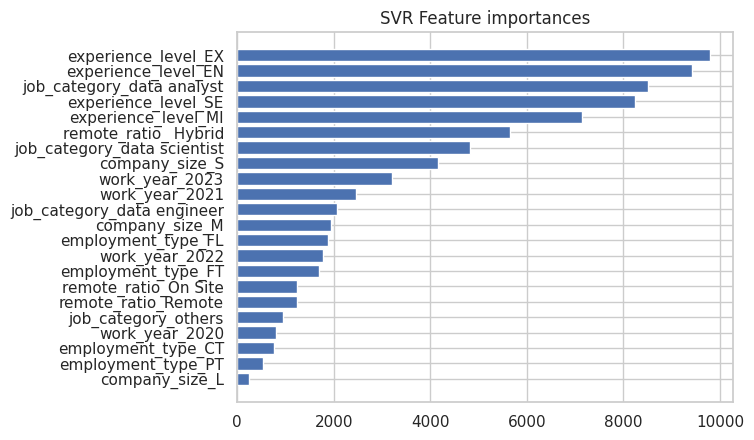

In [65]:
coef = best_svr.coef_.ravel()
importances = np.abs(coef)
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure()
plt.title("SVR Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.gca().invert_yaxis() 
plt.show()

## Final Remarks

In summary, job category and experience level are crucial determinants of salary in this dataset, with remote work options and company size also playing important roles. While there is evidence of significant differences in salary across different job categories, the disparity is not universal across all roles. Moreover, salary trends over time indicate both stability and variability, reflective of broader economic factors or industry-specific trends.